# Inference with Segment-NT models

[![Open All Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1TxQUaAc3scE8gFSL35uEUTf0ELNgE7gl?usp=sharing)

## Installation and imports

In [3]:
!pip install boto3
!pip install matplotlib
!pip install biopython
!pip install dm-haiku


In [1]:
import os

try:
    import nucleotide_transformer
except:
    !pip install numpy==1.23.5
    !pip install git+https://github.com/instadeepai/nucleotide-transformer@main |tail -n 1
    import nucleotide_transformer

if "COLAB_TPU_ADDR" in os.environ:
    from jax.tools import colab_tpu

    colab_tpu.setup_tpu()

In [2]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [3]:
from Bio import SeqIO
import gzip
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
from nucleotide_transformer.pretrained import get_pretrained_segment_nt_model

jax.config.update("jax_platform_name", "cpu")

backend = "cpu"
devices = jax.devices(backend)
num_devices = len(devices)
print(f"Devices found: {devices}")

Devices found: [CpuDevice(id=0)]


## Download the weights
The following cell allows you to download the weights of one of the Segment-NT models. It returns the weights dictionary, the haiku forward function, the tokenizer and the config dictionary.

Just like for the `get_pretrained_nucleotide_transformer` function, you can also specify:
1. the layers at which you'd like to collect embeddings (e.g. (5, 10, 20) to get embeddings at layers 5, 10 and 20)
2. the attention maps you´d like to collect (e.g. ((1,4), (7,18)) to get attention maps corresponding to layer 1 head number 4 and layer 7 head number 18). Please refer to the config to see the number of layers and heads in the model.
3. the maximum number of tokens in the sequences you'll compute the inference on. You can put values up to value specified in the model's config (counting the class token that will be added automatically at the beginning of the sequence), however we recommend keeping this number as small as possible for optimized memory and inference time.

In [5]:
# The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by
# the square of the number of downsampling block, i.e 4.
max_num_nucleotides = 8332

assert max_num_nucleotides % 4 == 0, (
    "The number of DNA tokens (excluding the CLS token prepended) needs to be dividible by"
     "2 to the power of the number of downsampling block, i.e 4.")

# If max_num_nucleotides is larger than what was used to train Segment-NT, the rescaling
# factor needs to be adapted.
if max_num_nucleotides > 5001:
    inference_rescaling_factor = max_num_nucleotides / 2048
else:
    inference_rescaling_factor=None

parameters, forward_fn, tokenizer, config = get_pretrained_segment_nt_model(
    model_name="segment_nt",
    rescaling_factor=inference_rescaling_factor,
    embeddings_layers_to_save=(29,),
    attention_maps_to_save=((1, 4), (7, 10)),
    max_positions=max_num_nucleotides + 1,
)
forward_fn = hk.transform(forward_fn)
apply_fn = jax.pmap(forward_fn.apply, devices=devices, donate_argnums=(0,))

# Put all on devices
random_key = jax.random.PRNGKey(seed=0)
keys = jax.device_put_replicated(random_key, devices=devices)
parameters = jax.device_put_replicated(parameters, devices=devices)

checkpoints/segment_nt/hyperparams.json


/home/hugo/.cache/nucleotide_transformer/segment_nt/hyperparams.json: 100%|██████████| 1.09k/1.09k [00:00<00:00, 30.5kB/s]
/home/hugo/.cache/nucleotide_transformer/segment_nt/ckpt.joblib: 100%|██████████| 2.25G/2.25G [01:19<00:00, 28.4MB/s]


# Get data

To reproduce the Fig.3 of the Segment-NT paper, we retrieve here the file of the 
human chromosome 20 and select the corresponding 50kb sequence.

### Download fasta file

In [12]:
! wget https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz

--2024-03-08 11:06:09--  https://ftp.ensembl.org/pub/release-111/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18833053 (18M) [application/x-gzip]
Saving to: ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz.3’

Homo_sapiens.GRCh38 100%[===================>]  17.96M  5.41MB/s    in 3.3s    

2024-03-08 11:06:12 (5.38 MB/s) - ‘Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz.3’ saved [18833053/18833053]



### Load sequence from chromosome and tokenize it

In [13]:
fasta_path = "Homo_sapiens.GRCh38.dna.chromosome.20.fa.gz"

with gzip.open(fasta_path, "rt") as handle:
    record = next(SeqIO.parse(handle, "fasta"))
    chr20 = str(record.seq)

In [14]:
idx_start = 5100000
idx_stop = idx_start + max_num_nucleotides*6

sequences = [chr20[idx_start:idx_stop]]
tokens_ids = [b[1] for b in tokenizer.batch_tokenize(sequences)]
tokens_str = [b[0] for b in tokenizer.batch_tokenize(sequences)]
tokens = jnp.asarray(tokens_ids, dtype=jnp.int32)[None, :]
tokens.shape


(1, 1, 8333)

# Infer the corresponding probabilities

In [15]:
# Infer
outs = apply_fn(parameters, keys, tokens)

# Obtain the logits over the genomic features
logits = outs["logits"]
# Transform them on probabilities
probabilities = np.asarray(jax.nn.softmax(logits, axis=-1))[...,-1]

/usr/local/lib/python3.10/dist-packages/jax/_src/interpreters/mlir.py:790: UserWarning: Some donated buffers were not usable: ShapedArray(float32[1024,8192]), ShapedArray(float32[4096,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,8192]), ShapedArray(float32[4096,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024]), ShapedArray(float32[1024,8192]

# Plot predictions

In [17]:
import seaborn as sns
from typing import List
import matplotlib.pyplot as plt

# seaborn settings
sns.set_style("whitegrid")
sns.set_context(
    "notebook",
    font_scale=1,
    rc={
        "font.size": 14,
        "axes.titlesize": 18,
        "axes.labelsize": 18,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        }
)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# set colors
colors = sns.color_palette("Set2").as_hex()
colors2 = sns.color_palette("husl").as_hex()

In [24]:
def plot_features(
    predicted_probabilities_all,
    seq_length: int,
    features: List[str],
    order_to_plot: List[str],
    fig_width=8,
):
    """
    Function to plot labels and predicted probabilities.

    Args:
        selected_features: selected feature names.
        n_panels: number of panels, including top panel with labels.
            For example, for two features per panel with 4 features, n_panels=3.
        pdf: save PDF.
        pdf_pages: pdf_pages object to add figures.
    """

    sc = 1.8
    n_panels = 7

    # fig, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 2) * sc), height_ratios=[6] + [2] * (n_panels-1))
    _, axes = plt.subplots(n_panels, 1, figsize=(fig_width * sc, (n_panels + 4) * sc))

    for n, feat in enumerate(order_to_plot):
        feat_id = features.index(feat)
        prob_dist = predicted_probabilities_all[:, feat_id]

        # Use the appropriate subplot
        ax = axes[n // 2]

        try:
            id_color = colors[feat_id]
        except:
            id_color = colors2[feat_id - 8]
        ax.plot(
            prob_dist,
            color=id_color,
            label=feat,
            linestyle="-",
            linewidth=1.5,
        )
        ax.set_xlim(0, seq_length)
        ax.grid(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['top'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.spines['left'].set_color('black')

    for a in range (0,n_panels):
        axes[a].set_ylim(0, 1.05)
        axes[a].set_ylabel("Prob.")
        axes[a].legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)
        if a != (n_panels-1):
            axes[a].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

    # Set common x-axis label
    axes[-1].set_xlabel("Nucleotides")
    # axes[0].axis('off')  # Turn off the axis
    axes[n_panels-1].grid(False)
    axes[n_panels-1].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)

    axes[0].set_title("Probabilities predicted over all genomics features", fontweight="bold")

    plt.show()


In [25]:
# Rearrange order of the features to match Fig.3 from the paper
features_rearranged = [
 'protein_coding_gene',
 'lncRNA',
 '5UTR',
 '3UTR',
 'exon',
 'intron',
 'splice_donor',
 'splice_acceptor',
 'promoter_Tissue_specific',
 'promoter_Tissue_invariant',
 'enhancer_Tissue_specific',
 'enhancer_Tissue_invariant',
 'CTCF-bound',
 'polyA_signal',
]

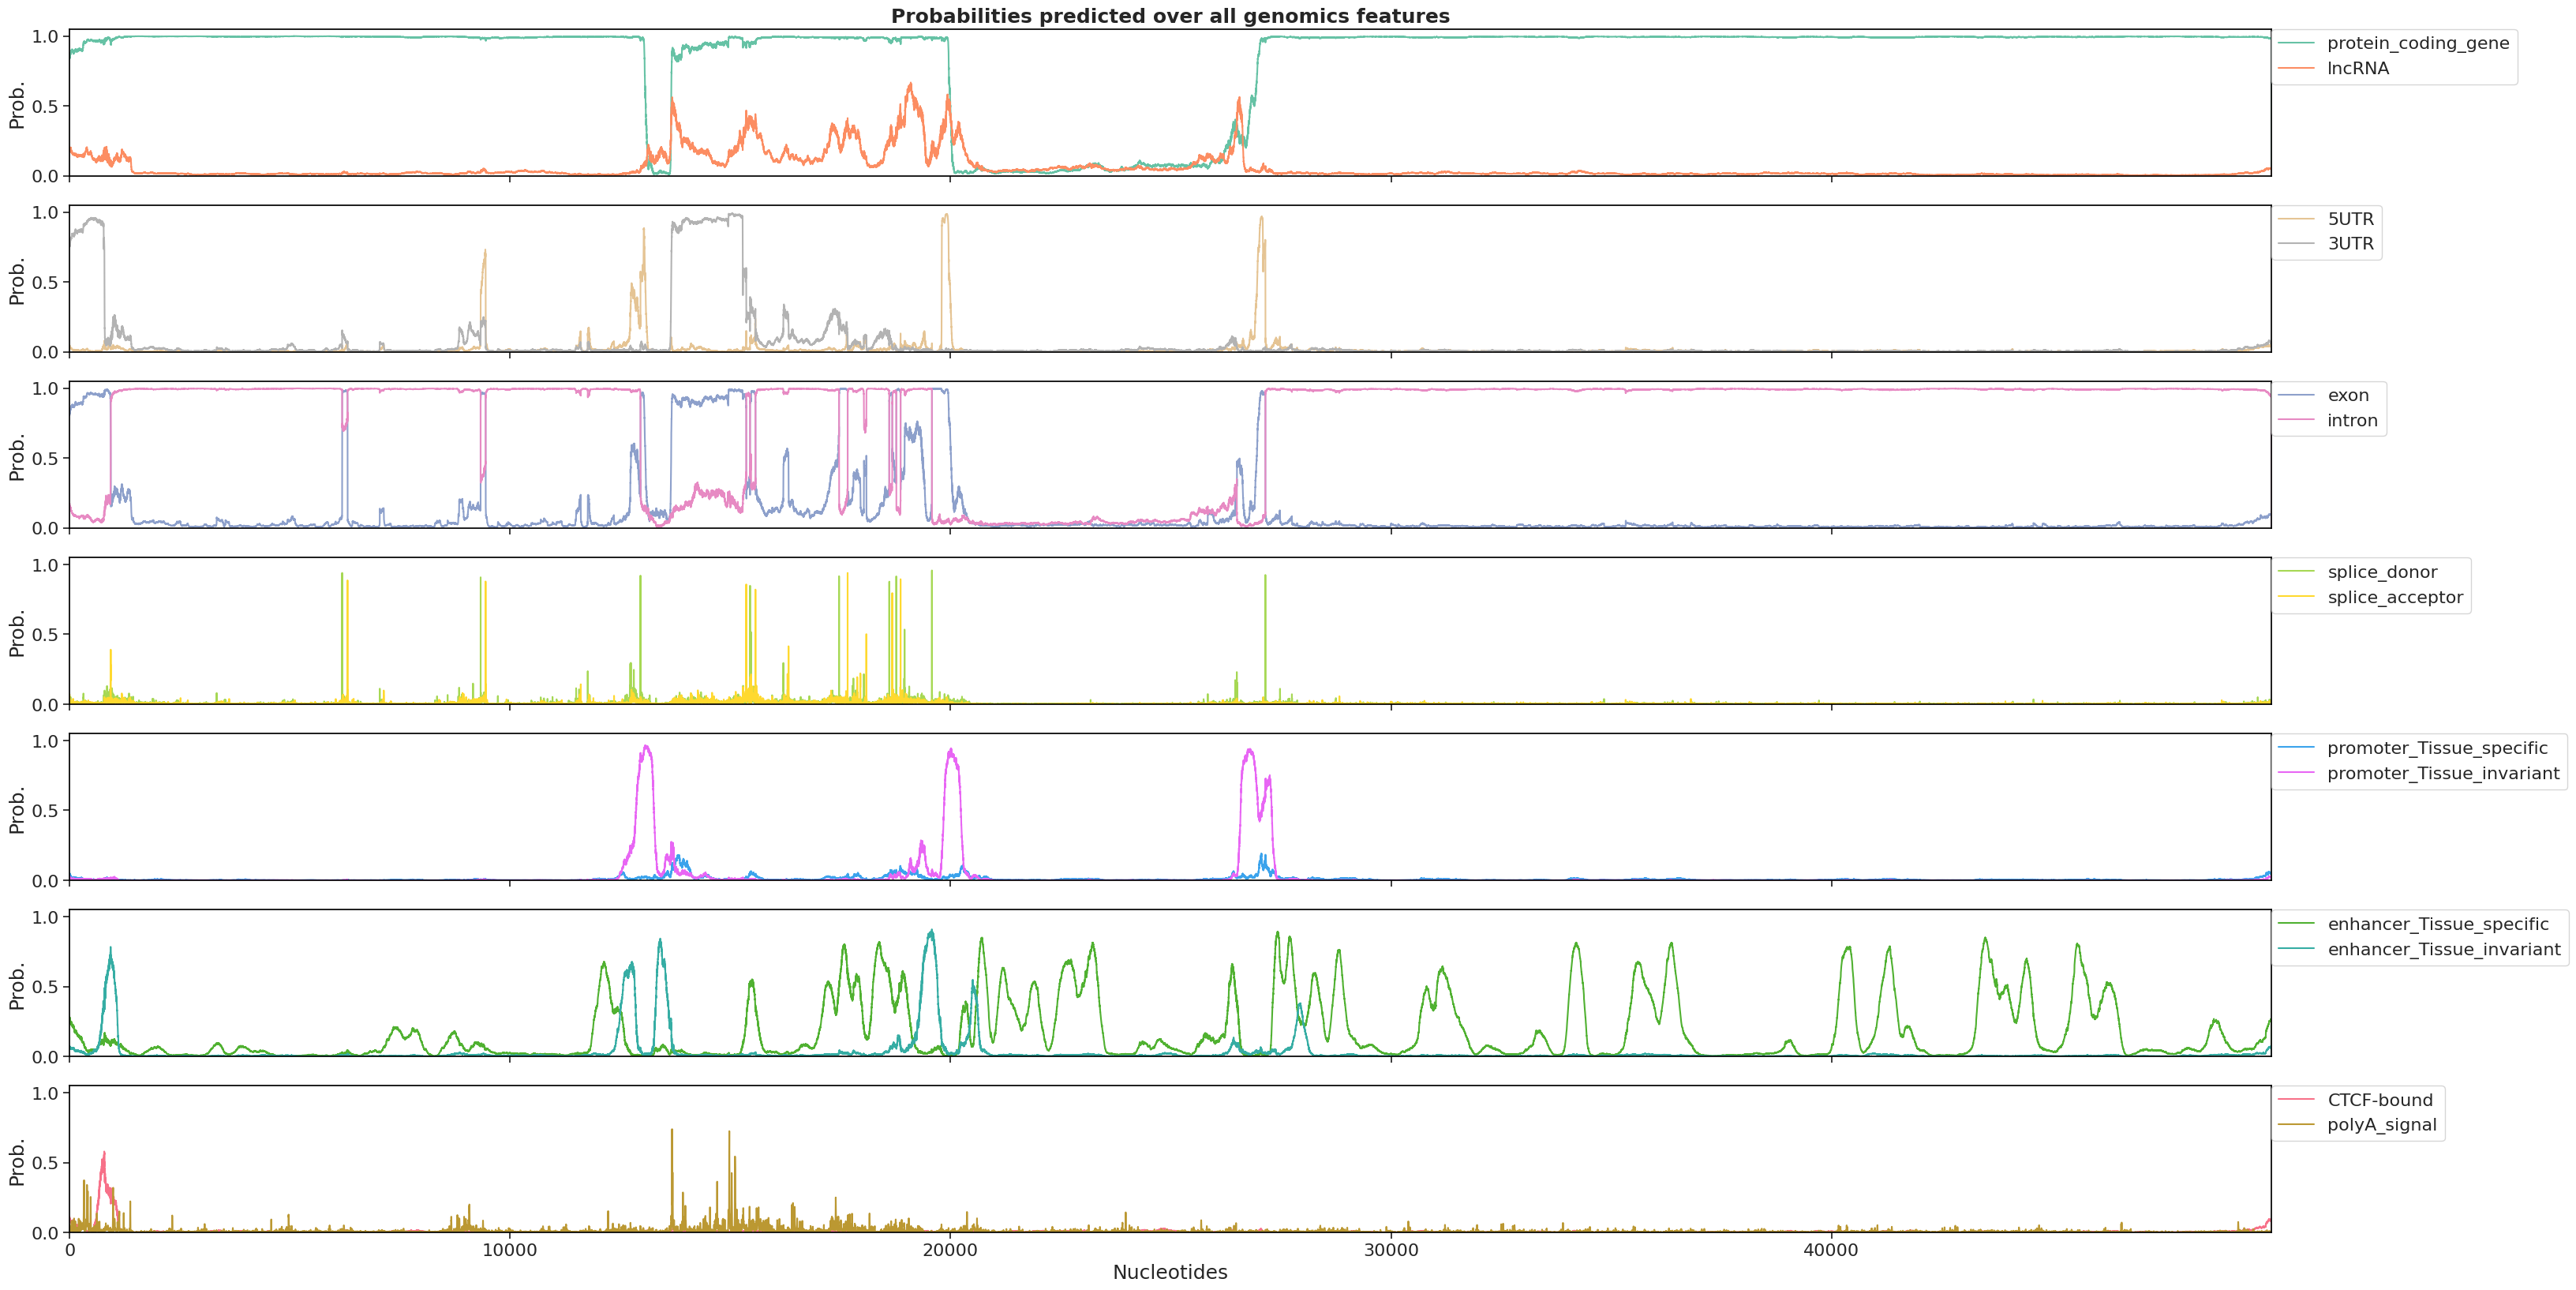

In [26]:
plot_features(
    probabilities[0,0],
    probabilities.shape[-2],
    fig_width=20,
    features=config.features,
    order_to_plot=features_rearranged
)